In [2]:
from astroquery.gaia import Gaia

job = Gaia.launch_job_async("""
SELECT
    source_id, ra, dec,
    parallax, pmra, pmdec,
    phot_g_mean_mag, bp_rp, ruwe
FROM gaiadr3.gaia_source
WHERE
    CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', 0.5, 67.4, 0.8)
    ) = 1
    AND parallax > 0
    AND parallax_over_error > 5
    AND ruwe < 1.4
    AND phot_g_mean_mag < 19
""")

Workaround solutions for the Gaia Archive issues following the infrastructure upgrade: https://www.cosmos.esa.int/web/gaia/news#WorkaroundArchive
INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
df = job.get_results().to_pandas()
print(len(df))
df.to_csv("berk59_gaia.csv", index=False)

df.head()

8991


,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,bp_rp,ruwe
0,528397633019065216,1.630626,66.735777,4.286450,-29.925151,-17.547881,16.427378,2.495100,0.947215
1,528398247196055680,1.469426,66.752306,0.745210,1.227025,-0.530153,18.566357,2.134024,1.064756
2,528427422912086784,0.374607,66.603399,0.849984,-0.068879,-2.346789,17.034399,2.283889,0.943833
3,528428724283221632,0.491964,66.624662,5.050598,-24.549907,14.729347,18.930342,3.025965,1.021886
4,528429106539774336,0.368713,66.670711,0.399716,-5.495169,0.995224,15.289734,2.762781,0.992820


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

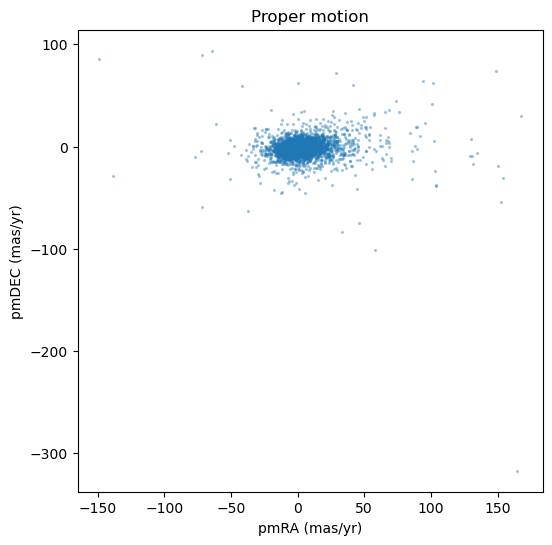

In [5]:
# phase space plot
# we will plot the data from the csv using matplotlib
# the y axis is the declination (north to south) and the x axis is the RIGHT ascension (west to east)
# they are the angle covered by a star in the celestial sphere per unit time; known as proper motion
# the cluster stars move together (share common motion), hence close in th plot, forming a lump or a cluster

plt.figure(figsize=(6,6))
plt.scatter(df.pmra, df.pmdec, s=2, alpha=0.3)
plt.xlabel('pmRA (mas/yr)') # milliarcseconds per year
plt.ylabel('pmDEC (mas/yr)')
plt.title('Proper motion')
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [7]:
X = df[['parallax', 'pmra', 'pmdec']].values 
# scaling done because they have different units, in order to ensure fair weighting of both
X_scaled = StandardScaler().fit_transform(X)

In [8]:
db = DBSCAN(eps=0.5, min_samples=10)

In [9]:
labels = db.fit_predict(X_scaled)

import numpy as np
np.unique(labels) 
# we have given label -1 to those stars outside the cluster using DBSCAN which finds overdensities in the plot

array([-1,  0])

In [10]:
df['cluster'] = labels

In [11]:
main_cluster = df['cluster'].value_counts().idxmax() 
members = df[df.cluster == main_cluster] # choose those IDs with label 0
members.head()

,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,bp_rp,ruwe,cluster
1,528398247196055680,1.469426,66.752306,0.745210,1.227025,-0.530153,18.566357,2.134024,1.064756,0
2,528427422912086784,0.374607,66.603399,0.849984,-0.068879,-2.346789,17.034399,2.283889,0.943833,0
4,528429106539774336,0.368713,66.670711,0.399716,-5.495169,0.995224,15.289734,2.762781,0.992820,0
5,528430137331409280,0.225320,66.617107,0.279565,-2.701130,-0.629890,14.693542,4.164883,1.102370,0
6,528431232544139776,0.074087,66.647750,0.759611,1.832033,2.983767,18.269604,2.934677,0.945806,0


In [12]:
print('Cluster members:', len(members))

Cluster members: 8476


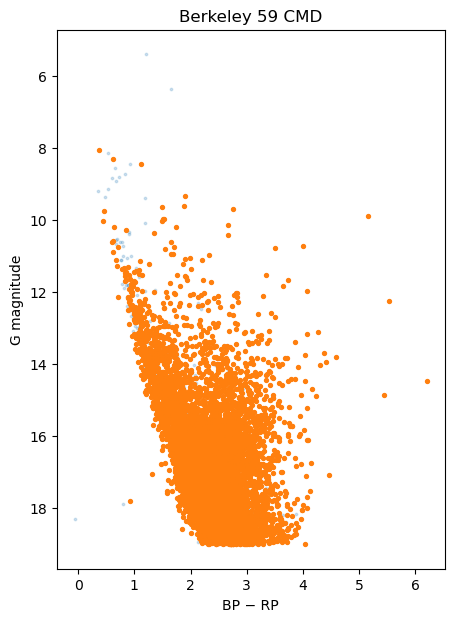

In [13]:
# cmd diagram 

plt.figure(figsize=(5,7))
plt.scatter(df.bp_rp, df.phot_g_mean_mag, s=3, alpha=0.2)
plt.scatter(members.bp_rp, members.phot_g_mean_mag, s=8)
plt.gca().invert_yaxis()
plt.xlabel('BP − RP') # color index (blue - red)
plt.ylabel('G magnitude') # analogous to apparent magnitude
plt.title('Berkeley 59 CMD')
plt.show()

# we can see **most** of the stars in berkeley 59 belong to the main sequence with a few exceptions

In [14]:
from astropy.io import fits
bands = ['g','r','i'] # different wavelength bands
images = {}
for b in bands:
    images[b] = fits.open(f'Berk_{b}.wcs.proc.fits')[0].data # importing the fits files (telescope images)

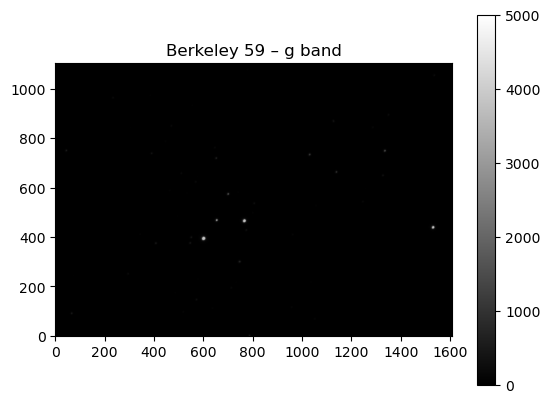

In [15]:
plt.imshow(images['g'], origin='lower', cmap='gray', vmin=0, vmax=5000)

plt.title('Berkeley 59 – g band')
plt.colorbar()
plt.show()

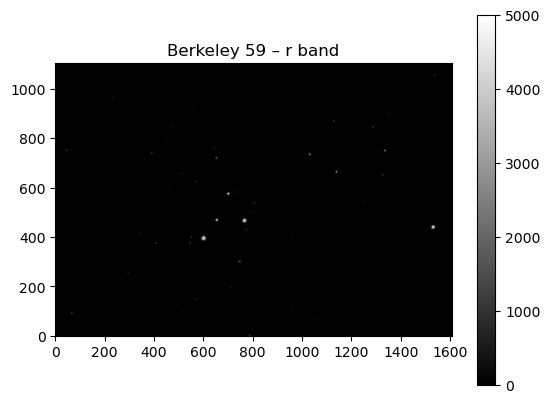

In [16]:
plt.imshow(images['r'], origin='lower', cmap='gray', vmin=0, vmax=5000)

plt.title('Berkeley 59 – r band')
plt.colorbar()
plt.show()

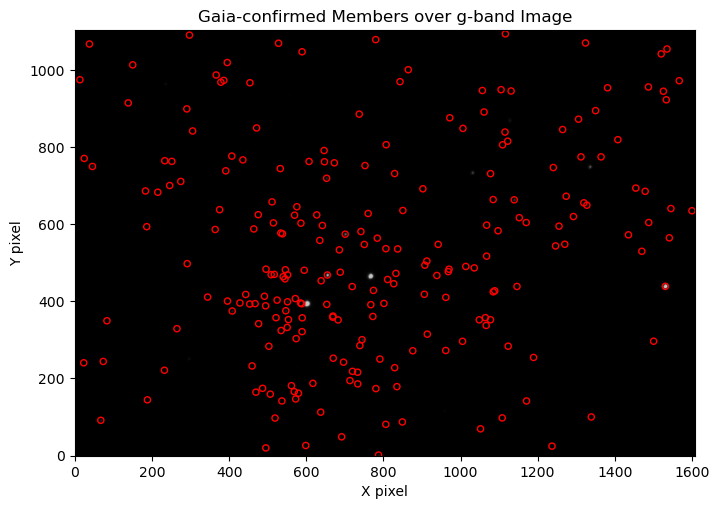

In [19]:
from astropy.wcs import WCS

hdr = fits.open('Berk_g.wcs.proc.fits')[0].header
wcs = WCS(hdr)

xpix, ypix = wcs.world_to_pixel_values(
    members.ra.values,
    members.dec.values
)

ny, nx = images['g'].shape

mask = (
    (xpix > 0) & (xpix < nx) &
    (ypix > 0) & (ypix < ny)
)

xpix = xpix[mask]
ypix = ypix[mask]

plt.figure(figsize=(8, 8))
plt.imshow(images['g'], origin='lower', cmap='gray', vmin=0, vmax=5000)
plt.scatter(
    xpix, ypix,
    s=20,
    edgecolor='red',
    facecolor='none',
    linewidth=1
)
plt.title('Gaia-confirmed Members over g-band Image')
plt.xlabel('X pixel')
plt.ylabel('Y pixel')
plt.show()